In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision



In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
import os
import requests


def download_files_from_github(repository_url, folder_path, file_extension='.py'):
    response = requests.get(f"{repository_url}/contents/{folder_path}")
    files = response.json()

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for file in files:
        if file['type'] == 'file' and file['name'].endswith(file_extension):
            file_url = file['download_url']
            file_content = requests.get(file_url).text

            file_path = os.path.join(folder_path, file['name'])
            with open(file_path, 'w') as f:
                f.write(file_content)

            print(f"Downloaded: {file_path}")


if __name__ == "__main__":
    repository_url = "https://api.github.com/repos/Riwaj22/Pytorch"
    folder_path = "Going Modular"
    file_extension = ".py"

    download_files_from_github(repository_url, folder_path, file_extension)

Downloaded: Going Modular/data_setup.py
Downloaded: Going Modular/evaluation_utils.py
Downloaded: Going Modular/github_downloader.py
Downloaded: Going Modular/plotting_curves.py
Downloaded: Going Modular/prediction_on_uploaded_image.py
Downloaded: Going Modular/training_utils.py


In [7]:
import sys
sys.path.append('/content/Going Modular')

import evaluation_utils, plotting_curves, prediction_on_uploaded_image, training_utils, data_setup
from data_setup import *
from evaluation_utils import *
from plotting_curves import *
from prediction_on_uploaded_image import *
from training_utils import *


In [8]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a43b3f987c0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7a43b3f9a5f0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 74.7MB/s]


RuntimeError: invalid hash value (expected "3dd342df", got "7f5810bc96def8f7552d5b7e68d53c4786f81167d28291b21c0d90e1fca14934")

In [ ]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear),
# let's set the seeds
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device))

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm


# Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm
from torch.utils.tensorboard import writer
# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [14]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [15]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [16]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [89]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders

# Create 20% training and test data DataLoders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)


In [116]:
import torchvision
from torch import nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb1():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
    model = torchvision.models.efficientnet_b1(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb1"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb7():

    weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
    model = torchvision.models.efficientnet_b7(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=2560 , out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb7"
    print(f"[INFO] Created new {model.name} model.")
    return model



In [117]:
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb5.classifier.state_dict()['1.weight'][0])}")


Number of in_features to final layer of EfficientNetB2: 2048


In [118]:
effnetb1 = create_effnetb1()


[INFO] Created new effnetb1 model.


In [119]:
effnetb7 = create_effnetb7()


[INFO] Created new effnetb7 model.


In [120]:
# 1. Create epochs list
num_epochs = [5, 10, 25,50]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb1", "effnetb7"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"train_data_loader": train_dataloader
                    }


In [121]:
from training_utils import train_step, test_step

In [122]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:
%%time

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in tqdm( num_epochs):

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 7. Select the model
            if model_name == "effnetb1":
                model = create_effnetb1() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb7() # creates a new model each time (important because we want each experiment to start from scratch)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model,
              train_data_loader=train_dataloader,
             test_data_loader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device=device,
              accuracy_fn=accuracy_fn
              )

In [124]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [127]:
def train_step(model, data_loader, optimizer, loss_fn, accuracy_fn, device):
    model.train()
    total_loss, total_corrects = 0.0, 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        total_corrects += torch.sum(predictions == targets.data)

    average_loss = total_loss / len(data_loader.dataset)
    accuracy = total_corrects.double() / len(data_loader.dataset)

    return average_loss, accuracy

def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_corrects = 0.0, 0

    with torch.inference_mode():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_corrects += torch.sum(predictions == targets.data)

    average_loss = total_loss / len(data_loader.dataset)
    accuracy = total_corrects.double() / len(data_loader.dataset)

    return average_loss, accuracy

def train(model, train_data_loader, test_data_loader, optimizer, loss_fn, accuracy_fn,
          epochs=5, early_stop_patience=3, device='cuda'):

    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_data_loader, optimizer, loss_fn, accuracy_fn, device)
        test_loss, test_acc = test_step(model, test_data_loader, loss_fn, accuracy_fn, device)

        print(f"Epoch:{epoch + 1} | Train Loss:{train_loss:.3f} | Train Accuracy:{train_acc:.3f} | Test Loss: {test_loss:.3f}| Test accuracy:{test_acc:.3f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in test loss.")
            break

    return results

# # main_script.py

# from training_utils import train

# # Example usage
# # Assuming you have defined your model, train_data_loader, test_data_loader, optimizer, loss_fn, accuracy_fn, and device

# results = train(model_0, train_data_loader, test_data_loader, optimizer, loss_fn, accuracy_fn, epochs=100, early_stop_patience=10)
# print(results)

In [126]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Helper function already exists")
else:
  print("Downloading file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import accuracy_fn

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

In [131]:
# Upload the results to TensorBoard.dev (uncomment to try it out)
!tensorboard dev upload --logdir runs \
    --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
    --description "Comparing results of different model size, training data amount and training time."

2024-02-01 11:27:37.109842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 11:27:37.109901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 11:27:37.111027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 11:27:38.105350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [132]:
model = create_effnetb1()

[INFO] Created new effnetb1 model.


In [133]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [141]:
train(model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn,
          epochs=5, early_stop_patience=3, device='cuda')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | Train Loss:1.019 | Train Accuracy:0.560 | Test Loss: 0.876| Test accuracy:0.893
Epoch:2 | Train Loss:0.810 | Train Accuracy:0.847 | Test Loss: 0.724| Test accuracy:0.907
Epoch:3 | Train Loss:0.669 | Train Accuracy:0.884 | Test Loss: 0.629| Test accuracy:0.907
Epoch:4 | Train Loss:0.559 | Train Accuracy:0.880 | Test Loss: 0.525| Test accuracy:0.933
Epoch:5 | Train Loss:0.533 | Train Accuracy:0.898 | Test Loss: 0.485| Test accuracy:0.933


{'train_loss': [1.0192166672812568,
  0.8095520570543078,
  0.668994590971205,
  0.5586990759107802,
  0.5334541625446744],
 'train_acc': [tensor(0.5600, device='cuda:0', dtype=torch.float64),
  tensor(0.8467, device='cuda:0', dtype=torch.float64),
  tensor(0.8844, device='cuda:0', dtype=torch.float64),
  tensor(0.8800, device='cuda:0', dtype=torch.float64),
  tensor(0.8978, device='cuda:0', dtype=torch.float64)],
 'test_loss': [0.8763387314478557,
  0.7244117474555969,
  0.6288263360659282,
  0.5245049293835958,
  0.4849625698725383],
 'test_acc': [tensor(0.8933, device='cuda:0', dtype=torch.float64),
  tensor(0.9067, device='cuda:0', dtype=torch.float64),
  tensor(0.9067, device='cuda:0', dtype=torch.float64),
  tensor(0.9333, device='cuda:0', dtype=torch.float64),
  tensor(0.9333, device='cuda:0', dtype=torch.float64)]}

In [142]:
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, data_loader, loss_fn, accuracy_fn, custom_labels):
    model = model.to("cuda")

    loss, acc = 0, 0
    all_true_labels, all_predicted_labels = [], []

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            y_pred = model(X)

            loss += loss_fn(y_pred, y).detach()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())

        loss /= len(data_loader)
        acc /= len(data_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average='macro', zero_division=0
    )

    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    result = {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix
    }

    plot_confusion_matrix(conf_matrix, custom_labels)

    return result

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=.5, annot_kws={"size": 24}, square=True)

    for i in range(len(labels)):
        plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='red', fontsize=24)

    plt.title('Confusion Matrix ')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

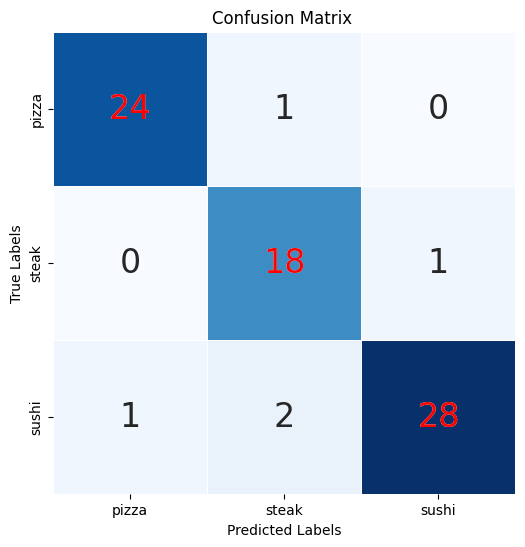

{'model_name': 'EfficientNet',
 'model_loss': 0.504970133304596,
 'model_acc': 92.8030303030303,
 'precision': 0.9275533661740559,
 'recall': 0.9368647425014148,
 'f1': 0.931111111111111,
 'confusion_matrix': array([[24,  1,  0],
        [ 0, 18,  1],
        [ 1,  2, 28]])}

In [143]:
evaluate_model(model, test_dataloader, loss_fn, accuracy_fn, class_names)

In [137]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
!pip install mlflow

In [ ]:
import mlflow
import mlflow.pytorch
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore")  # Ignore warnings
# Set the random seeds
set_seeds(seed=42)
# mlflow.end_run()
experiment_number = 0

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []



# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # Loop through each number of epochs
    for epochs in tqdm(num_epochs):

        # Loop through each model name and create a new model based on the name
        for model_name in models:

            # Create information print outs
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # Select the model
            if model_name == "effnetb1":
                model = create_effnetb1()
            else:
                model = create_effnetb7()

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train the model
            train_metrics = train(model,
                                  train_data_loader=train_dataloader,
                                  test_data_loader=test_dataloader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=epochs,
                                  device=device,
                                  accuracy_fn=accuracy_fn
                                  )

            # Append metrics for plotting
            train_losses.append(train_metrics['train_loss'])
            train_accuracies.append(train_metrics['train_acc'])
            test_losses.append(train_metrics['test_loss'])
            test_accuracies.append(train_metrics['test_acc'])

# Plotting
epochs_range = range(len(train_losses))

train_losses_flat = [item for sublist in train_losses for item in sublist]
test_losses_flat = [item for sublist in test_losses for item in sublist]

# Plotting
epochs_range = range(len(train_losses_flat))

for i, model_name in enumerate(models):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_range, train_losses[i], label=f'Train Loss - {model_name}', marker='o')
    plt.plot(epochs_range, test_losses[i], label=f'Test Loss - {model_name}', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train and Test Loss over Epochs - Model: {model_name}')
    plt.legend()
    plt.show()



In [181]:
!mlflow ui --port 5000


[2024-02-01 12:39:45 +0000] [42965] [INFO] Starting gunicorn 21.2.0
[2024-02-01 12:39:45 +0000] [42965] [INFO] Listening at: http://127.0.0.1:5000 (42965)
[2024-02-01 12:39:45 +0000] [42965] [INFO] Using worker: sync
[2024-02-01 12:39:45 +0000] [42966] [INFO] Booting worker with pid: 42966
[2024-02-01 12:39:45 +0000] [42967] [INFO] Booting worker with pid: 42967
[2024-02-01 12:39:45 +0000] [42968] [INFO] Booting worker with pid: 42968
[2024-02-01 12:39:45 +0000] [42973] [INFO] Booting worker with pid: 42973
[2024-02-01 12:42:09 +0000] [42965] [INFO] Handling signal: int

Aborted!
[2024-02-01 12:42:09 +0000] [42966] [INFO] Worker exiting (pid: 42966)
[2024-02-01 12:42:09 +0000] [42968] [INFO] Worker exiting (pid: 42968)
[2024-02-01 12:42:09 +0000] [42967] [INFO] Worker exiting (pid: 42967)
[2024-02-01 12:42:09 +0000] [42973] [INFO] Worker exiting (pid: 42973)
[2024-02-01 12:42:09 +0000] [42965] [INFO] Shutting down: Master
